In [15]:
import gpustat
import numpy as np
import matplotlib as plt
import pandas as pd

import torch
import torch.nn as nn

import glob
from skimage import io
from PIL import Image

from torch.utils.data import DataLoader, Sampler
from torchvision import datasets
from torchvision.transforms import transforms

import torchvision
from torch.utils.data import DataLoader, Sampler


import matplotlib.pyplot as plt
%matplotlib inline

## Data Loading

In [16]:
train_path = "/home/timur/s2/projects/ConvNet_fruits360/data/Training"
test_path  = "/home/timur/s2/projects/ConvNet_fruits360/data/Test"

#### Train and validation

In [8]:
#Create Datasets class object
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize( (0.5,0.5,0.5), (0.5,0.5,0.5) )])
dataset = datasets.ImageFolder(train_path, transform = transformation)

#Parameters
val_split = 0.2
train_size = dataset.__len__()

#Create indices and shuffle them
indice = list(range(train_size))
np.random.shuffle(indice)

#split indices into training and validation
split = round(val_split * train_size)
train_indices, val_indices = indice[split:], indice[:split]

#Samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices) 

#Loaders
train_loader = DataLoader(dataset=dataset, batch_size=32, sampler= train_sampler)
val_loader = DataLoader(dataset=dataset, batch_size=32, sampler = val_sampler)

#### Test

In [18]:
test_dataset = torchvision.datasets.ImageFolder(test_path, transform = transformation)
## Test loader
test_loader = DataLoader(test_dataset, batch_size = 32)

#### Toy dataset to test code

In [19]:
### Create toy dataset to check  implementation
np.random.seed(42)

toy_size = 1000
toy_batch = 32

tr_toy_ind = np.random.choice(train_indices, size = toy_size) 
val_toy_ind = np.random.choice(val_indices, size = toy_size) 


train_toy_sampler = torch.utils.data.SubsetRandomSampler(tr_toy_ind)
val_toy_sampler = torch.utils.data.SubsetRandomSampler(val_toy_ind) 

train_toy_loader = DataLoader(dataset=dataset, batch_size=toy_batch, sampler= train_toy_sampler)
val_toy_loader = DataLoader(dataset=dataset, batch_size= toy_batch, sampler = val_toy_sampler)

### Random visualization

In [7]:
def visualize_random_image(number):
    
        for num,idx in enumerate(np.random.randint(0, train_loader.dataset.__len__() , size = number)):
            path, target = train_loader.dataset.imgs[idx]
            img = Image.open(path)
            ax = plt.subplot(200+ number//2 * 10+1+num,)
            ax.set_title(dataset.class_to_idx.get(target))
            ax.imshow(img)
            ax.axis("off")

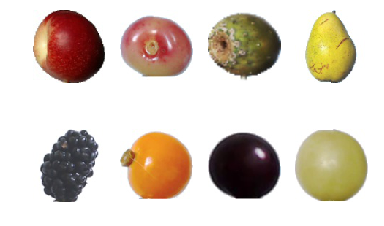

In [9]:
visualize_random_image(8)

### Batch layer

In [176]:
# Input - X (batch_size,(height, width, channels))
# dtype - torch.Tensor
# (64,3,h,w)

class BatchNormCustom(nn.Module):
    
    def __init__(self, gamma = 1, beta = 0, eps = 1e-5):
        super().__init__()
        self.X = None
        self.gamma = torch.FloatTensor(gamma)
        self.beta = torch.FloatTensor(beta)
        self.eps = torch.tensor(eps)
        
    def forward(self,X):
        self.X = X
        m  = X.shape[0]
        mu = torch.mul((1/m),torch.sum(X, 0))
        var = torch.mul((1/m),torch.sum((X - mu) ** 2, 0))
        X_norm = (X - mu)/torch.sqrt(var + self.eps)
        return  self.gamma * X_norm + self.beta

    def params(self):
        return { 'gamma': self.gamma, 'beta': self.beta}

bt_n = nn.Sequential(BatchNormCustom(),Flattener(),nn.Linear(3 * 100 * 100, 10))
loss_b = nn.CrossEntropyLoss()

X_b = torch.randn((32,3,100,100), requires_grad=True)
Y_b = torch.empty(32, dtype=torch.long).random_(10)


output = bt_n(X_b)
loss = loss_b(output,Y_b)
loss.backward()


### Defining model, loss function, optimizer

In [48]:
class Flattener(nn.Module):  

    def forward(self,X):
        self.X_shape = X.shape
        return X.view(self.X_shape[0],-1)

    
model = nn.Sequential(nn.Conv2d(3,20,5, bias = False),
                      nn.BatchNorm2d(20),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(4),
                      nn.Conv2d(20,20,5, bias = False),
                      nn.BatchNorm2d(20),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(4),
                      Flattener(),
                      nn.Linear(20 * 5 *5, 96, bias = True)
                     )
device = torch.device("cuda:0")

model.to(device)
model.type(torch.cuda.FloatTensor)

if torch.cuda.device_count() > 1:
    print("GPU: ", torch.cuda.device_count())
    model = nn.DataParallel(model)


loss_f = nn.CrossEntropyLoss(reduction = "mean").type(torch.cuda.FloatTensor)
optim = torch.optim.Adam(model.parameters(),lr = 1e-1, weight_decay=1e-3)

### Compute accuracy for given model and data loader

In [11]:
def compute_accuracy(model, data_loader):
    model.eval()
    
    correct_prediction = 0
    total_samples = 0
    batch_size = data_loader.batch_size
    
    for x,y in data_loader:
        x_device = x.to(device)
        y_device = y.to(device)
        
        output = model(x_device)
        prediction = torch.argmax(output,1)
        correct_prediction += torch.sum(prediction == y_device)
        total_samples += batch_size
        
    return float(correct_prediction)/ total_samples

### Training function

In [49]:
def train(model, train_loader, validation_loader, loss, optimizer,num_epochs):
    train_loss_history, train_acc_history, val_acc_history = [], [], []
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5)
    for epoch in range(num_epochs):
        model.train()
        
        scheduler.step()
        
        train_loss = 0
        correct_train_samples = 0.
        total_train_samples = len(train_loader.sampler.indices)
        for i_batch, (x,y) in enumerate(train_loader):
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            
            output = model(x_gpu)
            prediction = torch.argmax(output,1)
            loss_value = loss(output,y_gpu)
            
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
                
            train_loss += loss_value
            correct_train_samples += torch.sum(prediction == y_gpu)
            torch.cuda.empty_cache()
            
        train_acc = float(correct_train_samples) / total_train_samples
        val_acc = compute_accuracy(model,validation_loader)
        
        train_loss_history.append(train_loss/ (i_batch+1))
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)
        
        torch.cuda.empty_cache()
        #print("Epoch : %d, Train loss - %f, train_acc - %f, val_acc - %f" % (epoch+1, train_loss, train_acc, val_acc))
    
    return train_loss_history, train_acc_history, val_acc_history
        
train_loss_history, train_acc_history, val_acc_history = train(model, train_toy_loader, val_toy_loader, loss_f, optim, 10) 

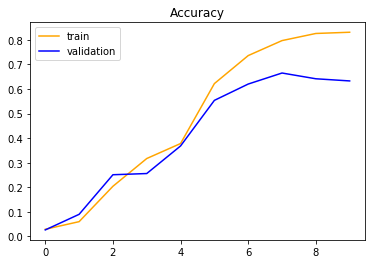

In [50]:
plt.plot(train_acc_history, color="orange")
plt.plot(val_acc_history, color = "blue")
plt.legend(("train", "validation"))
plt.title("Accuracy");

Text(0.5, 1.0, 'Training Loss history')

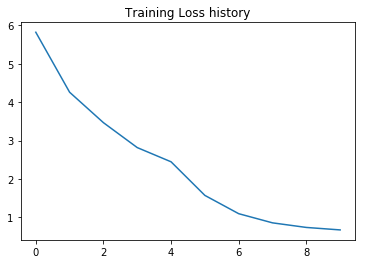

In [51]:
plt.plot(train_loss_history)
plt.title("Training Loss history")

In [34]:
compute_accuracy(model,test_loader)

0.9371960116731517

### Grid Search

In [33]:
regularization = [1e-0,1e-1, 1e-2, 1e-3, 1e-4] 
learning_rate = [1e-1, 1e-2, 1e-3]


In [19]:
device = torch.device("cuda:0")

model = nn.Sequential(nn.Conv2d(3,20,5, bias = False),
                      nn.BatchNorm2d(20),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(4),
                      nn.Conv2d(20,10,5, bias = False),
                      nn.BatchNorm2d(10),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(4),
                      Flattener(),
                      nn.Linear(10 * 5 *5, 96, bias = True)
                     )
model.to(device)
model.type(torch.cuda.FloatTensor)

if torch.cuda.device_count() > 1:
    print("GPU: ", torch.cuda.device_count())
    model = nn.DataParallel(model)


In [20]:
!mkdir models

param_dict = {}


for reg in regularization:
    for lr in learning_rate:
            loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
            optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay= reg )
            
            loss_history, train_history, val_history = training(model,train_loader,val_loader,loss, optimizer, 50) 
            key = "RG: "+reg+" "+"LR: "+lr
            param_dict[key] = val_history[-1]
            
            torch.save(model.state_dict(), "/models/"+key)

!zip -r models.zip models/ 

from google.colab import files
files.download("file.zip")

OSError: [Errno 12] Cannot allocate memory

mkdir: cannot create directory ‘models’: File exists


### Save model state into file

  adding: models/ (stored 0%)
  adding: models/m2d (deflated 9%)
  adding: models/md (deflated 9%)


### Test